In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 1
%aimport numpy_api_stats

In [3]:
import numpy_api_stats as ns
import pandas as pd


## Results

In [4]:
accumulated_results_fn = 'full_results_4_10_2019.csv'

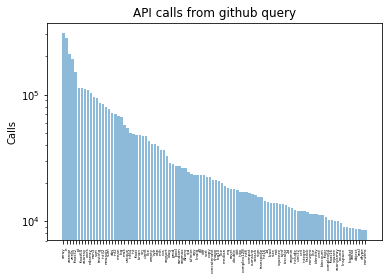

In [5]:
ns.plot_results(pd.read_csv(accumulated_results_fn),savefig=True,filename='results.png',dpi=200)

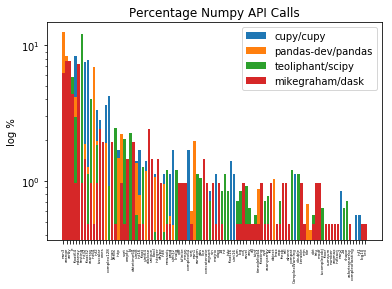

In [6]:
accumulated_results_by_project = 'percent_by_project.csv'
det_percentages = pd.read_csv(accumulated_results_by_project).set_index('index')
f1 = ns.plot_bar_repo(det_percentages)
f1.savefig('bar_repo.png', dpi=200)

In [8]:
det_percentages

,numpy_float_nan3_count,numpy_builtin_function_or_method_arange_count,numpy_builtin_function_or_method_array_count,numpy_float_e_count,numpy_type_float64_count,numpy_type_ndarray_count,numpy_module_testing_count,numpy_type_int32_count,numpy_type_float32_count,numpy_function_asarray_count,...,numpy_type_memmap_count,numpy_function_triu_indices_count,numpy_function_triu_indices_from_count,numpy_function_typename_count,numpy_function_union1d_count,numpy_type_longlong_count,numpy_function_var_count,numpy_function_vsplit_count,numpy_function_who_count,numpy_module__distributor_init_count
index,,,,,,,,,,,,,,,,,,,,,
cupy/cupy,0.028011,0.028011,0.036415,0.044818,0.084034,0.028011,0.005602,0.075630,0.078431,0.016807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pandas-dev/pandas,0.124752,0.083035,0.058800,0.046881,0.041319,0.036154,0.000000,0.018673,0.012714,0.035360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
teoliphant/scipy,0.016243,0.038842,0.033192,0.058616,0.029661,0.023305,0.122175,0.004944,0.011299,0.040254,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mikegraham/dask,0.062802,0.077295,0.077295,0.043478,0.009662,0.072464,0.009662,0.014493,0.004831,0.009662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Analysis

In [9]:
import os
os.environ['GOOGLE_CRED_DIR']=os.path.join(os.environ['HOME'],'creds')
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=os.path.join(os.environ['GOOGLE_CRED_DIR'],'apt-footing-235018-aeb185ac9e31.json')

#### Investigate bigQuery public github dataset contents using bqhelper

In [10]:
#from google.cloud import bigquery
github_repos = ns.BigQueryHelper(active_project= "bigquery-public-data", 
                                       dataset_name = "github_repos")

In [11]:
github_repos.list_tables()

['commits',
 'contents',
 'files',
 'languages',
 'licenses',
 'sample_commits',
 'sample_contents',
 'sample_files',
 'sample_repos']

In [12]:
api_results = ns.BigQueryHelper(active_project= "apt-footing-235018", 
                                       dataset_name = "NumpyAPI")

In [13]:
api_results.list_tables()

['content',
 'files',
 'functions',
 'imports',
 'latest_numpy',
 'latest_numpy_agg_repo_from_list',
 'latest_numpy_agg_repo_name',
 'methods',
 'ohNulllllll',
 'projects',
 'pypi_downloads_that_import_numpy',
 'pypi_downloads_this_week',
 'repos_that_import_numpy',
 'repos_that_import_numpy_split',
 'reposlikelist',
 'results',
 'results2',
 'results3',
 'results4',
 'results_4_10_2019',
 'sample_results',
 'watched',
 'watched_python',
 'watched_sample_files']

In [15]:
agg_results = api_results.head("latest_numpy_agg_repo_name",num_rows=10)
agg_results

,repo_name,f0_,numpy_module__distributor_init_count,numpy_module__globals_count,numpy_module__import_tools_count,numpy_module__mat_count,numpy_module__mklinit_count,numpy_module_add_newdocs_count,numpy_module_char_count,numpy_module_compat_count,...,numpy_nd_grid_ogrid_count,numpy__Feature_absolute_import_count,numpy__Feature_division_count,numpy__Feature_print_function_count,numpy_dict_sctypeDict_count,numpy_dict_sctypeNA_count,numpy_dict_sctypes_count,numpy_dict_typeDict_count,numpy_dict_typeNA_count,numpy_dict_typecodes_count
0,gforcada/jenkins-job-builder,122,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,RobinCPC/algorithm-practice,80,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,matthewrmshin/cylc,211,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,sviete/AIS-EXT,65,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tony-joseph/livre,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,hotsyk/uapython2,49,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,thinkopensolutions/l10n-brazil,552,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Crystalnix/serverauditor-sshconfig,92,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,xuxiaoxin/micropython,622,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,frt-arch/taiga-back,477,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create dataframe for plot  This pulls aggregate table from BigQuery, formats for plot, and saves to .csv 

#Create dataframe for plot  This pu
_list_agg = api_results.query_to_pandas_safe('''
SELECT * FROM `apt-footing-235018.NumpyAPI.latest_numpy_agg_repo_from_list`
''')

list_agg = _list_agg.set_index('repo_name')

list_agg = list_agg.drop(['f0_','numpy_module_numpy_count'],axis=1)

scipy_api = list_agg.loc['teoliphant/scipy']
Nscipy = scipy_api.sum()

cupy_api = list_agg.loc['cupy/cupy']
Ncupy = cupy_api.sum()

dask_api = list_agg.loc['mikegraham/dask']
Ndask = dask_api.sum()

pandas_api = list_agg.loc['pandas-dev/pandas']
Npandas = pandas_api.sum()

det_percentages = pd.DataFrame([cupy_api/Ncupy, pandas_api/Npandas, scipy_api/Nscipy, dask_api/Ndask])

det_percentages = det_percentages[ det_percentages.mean().sort_values(ascending=False).index ]

det_percentages.reset_index().to_csv('percent_by_project.csv',index=False)

### The following is some analysis of API member functions and experiments with query generation Construct API datasets

In [18]:
import numpy as np
import pandas as pd

api = [(x, type(np.__getattribute__(x))) for x in dir(np) if not x.startswith('__')]
things = set([ x[1].__name__ for x in api])
names = set([ x[0] for x in api])
df_api = pd.DataFrame(api,columns=['name','type'])

array_type = df_api[df_api.name=='array']
things_of_array_type = df_api[df_api.type == array_type.type.values[0]]
#things_of_array_type

In [19]:
df_api[df_api.name=='linalg']

,name,type
339,linalg,<class 'module'>


In [20]:
GoogleSheet = pd.read_csv('NumPy API - Sheet2.csv')
names_from_sheet = GoogleSheet['NumPy API']

In [21]:
valid_names = set(names_from_sheet)-set(['Functions','bench',np.nan])

In [22]:
new_names = set(names)-set(names_from_sheet)

In [23]:
df_valid_from_sheet = df_api.set_index('name').loc[valid_names]
df_valid_from_sheet = df_valid_from_sheet.reset_index()
df_valid_from_sheet['type'] = df_valid_from_sheet.type.apply(lambda x: x.__name__)
df_valid_from_sheet.head()

,name,type
0,irr,function
1,float_power,ufunc
2,version,module
3,ndfromtxt,function
4,bitwise_xor,ufunc


#### How many of each type in the api are represented in the Google Sheet?

In [24]:
df_valid_from_sheet[['type','name']].groupby(['type']).count().sort_values('name')

,name
type,
CClass,1
NoneType,1
PytestTester,1
RClass,1
bool,1
int,1
IndexExpression,2
_typedict,2
str,2


#### Of which, the following have not been implemented

In [25]:
df_valid_from_sheet.set_index('type').loc[['CClass','NoneType','PytestTester','RClass','bool','IndexExpression','_typedict','str','nd_grid','_Feature','dict']]

,name
type,
CClass,c_
NoneType,newaxis
PytestTester,test
RClass,r_
bool,little_endian
IndexExpression,index_exp
IndexExpression,s_
_typedict,nbytes
_typedict,cast


#### Query Constructed for API functions..  

In [26]:
# Selecting just a few for demonstration, Query price is independent of # of regex though, so it is better to actually run
# with all at once.

funs = ns.select(api,'function')
mods = ns.select(api,'module')
ints = ns.select(api,'int')
floats = ns.select(api,'float')
ufuncs = ns.select(api,'ufunc')
api_list = funs[:2]+mods[:2]+ints[:2]+floats[:2]+ufuncs[:2]

In [27]:
# Use all to build full query running 
#api_list=ns.build_api_list(api)

In [28]:
len(api_list)

10

In [29]:
import numpy_api_stats as ns
apq = ns.API_QUERY_FACTORY(api_list=api_list)
#apq = ns.API_QUERY_FACTORY()
print(apq.query)

SELECT
repo_name,
path,
REGEXP_MATCH( c.content,'(np\\.|numpy\\.)add_newdoc\\(\\s?[A-Za-z0-9_.\\(\\)]*\\s?\\)' ) AS numpy_function_add_newdoc,
REGEXP_MATCH( c.content,'(np\\.|numpy\\.)alen\\(\\s?[A-Za-z0-9_.\\(\\)]*\\s?\\)' ) AS numpy_function_alen,
REGEXP_MATCH(c.content,'(import\\s+numpy\\._distributor_init|from\\s+numpy\\s+import\\s+_distributor_init|from\\s+numpy\\._distributor_init import\\s+[A-za-z0-9_.]+)' ) AS numpy_module__distributor_init,
REGEXP_MATCH(c.content,'(import\\s+numpy\\._globals|from\\s+numpy\\s+import\\s+_globals|from\\s+numpy\\._globals import\\s+[A-za-z0-9_.]+)' ) AS numpy_module__globals,
REGEXP_MATCH(c.content,'(np\\.|numpy\\.)ALLOW_THREADS' ) AS numpy_int_ALLOW_THREADS,
REGEXP_MATCH(c.content,'(np\\.|numpy\\.)BUFSIZE' ) AS numpy_int_BUFSIZE,
REGEXP_MATCH(c.content,'(np\\.|numpy\\.)Inf\\s*[\\*\\+\\-\\/]?' ) AS numpy_float_inf1,
REGEXP_MATCH(c.content,'(np\\.|numpy\\.)Infinity\\s*[\\*\\+\\-\\/]?' ) AS numpy_float_Infinity,
REGEXP_MATCH(c.content,'(np\\.|numpy\

### AFter copying and pasting the above query into BigQuery and saving as sample_results... 

#####Unfortunately this doesn't work https://github.com/dask/dask/issues/3121 so we manually export results.

##### Pull data from bigQuery.  This is a one row table with a a few hundred columns so is relatively inexpensive to pull, but we'll download a local copy and work from that anyway to reduce wear on our ISP's routers.

#### references
- [Florin Badita](https://medium.com/google-cloud/naming-conventions-in-python-import-statements-a-bigquery-adventure-using-the-github-db-dump-d900159ab680)
- [Felipe Hoffa](https://medium.com/google-cloud/github-on-bigquery-analyze-all-the-code-b3576fd2b150)
- [Walker Harrison](https://dev.to/walker/using-googles-bigquery-to-better-understand-the-python-ecosystem)
- [Robert Kozikowski](https://kozikow.com/2016/06/05/more-advanced-github-code-search/)
- [Poonam Ligade](https://www.kaggle.com/poonaml/analyzing-3-million-github-repos-using-bigquery)
- [Sohier Dane](https://github.com/SohierDane/BigQuery_Helper/blob/master/bq_helper.py)
- [Google BigQuery](https://cloud.google.com/bigquery/docs/reference/legacy-sql)
- [Cloud API](https://googleapis.github.io/google-cloud-python/latest/bigquery/usage/queries.html)
- [Numpy API](https://docs.google.com/spreadsheets/d/10Tf_FK4FHaS0rpgBIuK43RHTPR601RD4p39gZQRZ2Yg/edit#gid=74265489)
- [Numpy Book](https://docs.scipy.org/doc/_static/numpybook.pdf)

#### Next steps may require UDF ( javascript ) for better python parsing, and thus bias reduction in api detection
[ Big Query UDF ](https://cloudplatform.googleblog.com/2015/08/Google-BigQuery-adds-UDF-support-for-deeper-cloud-analytics.html)
[ UDF Test Tool](http://storage.googleapis.com/bigquery-udf-test-tool/testtool.html)

#### Search in popular repos for numpy dependencies

In [43]:
import sys
import inspect
import ast
sys.path.insert(0,'~/SCIPY/build/lib.macosx-10.7-x86_64-3.7/')

In [44]:
from scipy import linalg

In [45]:
mlist= inspect.getmembers(linalg)
#mlist = mlist[2][1]   

In [46]:
inspect.getfile(linalg)

'/Users/mpeaton/SCIPY/build/lib.macosx-10.7-x86_64-3.7/scipy/linalg/__init__.py'

In [47]:
ast.parse(inspect.getsource(linalg))

In [48]:
import ast
import inspect
import scipy


src = inspect.getsource(inspect.getfile(scipy))
tree=ast.parse(src)
for node in ast.walk(tree):
    if isinstance(node, ast.ImportFrom):
        print(node.module,[n.name for n in node.names])
    elif isinstance(node,ast.Import):
        print([n.name for n in node.names])

TypeError: module, class, method, function, traceback, frame, or code object was expected, got str

In [49]:
print(inspect.getsource(scipy))

"""
SciPy: A scientific computing package for Python

Documentation is available in the docstrings and
online at https://docs.scipy.org.

Contents
--------
SciPy imports all the functions from the NumPy namespace, and in
addition provides:

Subpackages
-----------
Using any of these subpackages requires an explicit import.  For example,
``import scipy.cluster``.

::

 cluster                      --- Vector Quantization / Kmeans
 fftpack                      --- Discrete Fourier Transform algorithms
 integrate                    --- Integration routines
 interpolate                  --- Interpolation Tools
 io                           --- Data input and output
 linalg                       --- Linear algebra routines
 linalg.blas                  --- Wrappers to BLAS library
 linalg.lapack                --- Wrappers to LAPACK library
 misc                         --- Various utilities that don't have
                                  another home.
 ndimage                      --- n-